In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import os
import PIL
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, mean_squared_error, confusion_matrix

# 1 - Load dataset

In [210]:
dataset = {}

for d in os.walk('./Data/images_original/'):
    curr_genre = d[0].split('/')[-1]
    
    if '.DS_Store' in d[2]: continue
        
    print(curr_genre)
    print(d[0])
    
    dataset[curr_genre] = []
    
    for img in d[2]:
        img_path = os.path.join(d[0], img)

        image = PIL.Image.open(img_path)
        image = image.resize((130, 87))
        image_array = np.array(image)
        
        dataset[curr_genre].append(image_array)

pop
./Data/images_original/pop
metal
./Data/images_original/metal
disco
./Data/images_original/disco
blues
./Data/images_original/blues
reggae
./Data/images_original/reggae
classical
./Data/images_original/classical
rock
./Data/images_original/rock
hiphop
./Data/images_original/hiphop
country
./Data/images_original/country
jazz
./Data/images_original/jazz


# 2 - Pre-process dataset

## 2.1 - Remove margins
Every loaded image in the dataset contains white margins, and in this section I'll be removing them since they don't add any significance to the task at hand and only increase the computational power needed to train the model.

In [211]:
for genre in list(dataset.keys()):
    for i in range(len(dataset[genre])):
        img = dataset[genre][i]
        new_img = []
        for h in range(10, len(img) - 10):
            new_img.append(img[h][16:len(img[h])-12])
        new_img = np.array(new_img)
        dataset[genre][i] = new_img
        

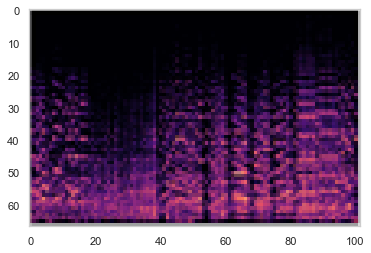

In [212]:
plt.imshow(dataset['classical'][42])

## 2.2 - Image normalization
The images in the dataset have values between 0 and 255, and to be fed into a CNN, they need to be between 0 and 1, which is exactly what I'll be doing in this section.

In [213]:
for genre in list(dataset.keys()):
    for i in range(len(dataset[genre])):
        dataset[genre][i] = dataset[genre][i] / 255.0

## 2.3 - Image channel selection and image flattening
For now, I'll be removing the alpha channel from the dataset, since it doesn't add any information to the data. Besides that, I will also reshape the images into a single array for each one.

In [85]:
dataset['classical'][0][0][0]

array([0.68235294, 0.68235294, 0.68627451, 1.        ])

In [214]:
new_dataset = {}
for genre in list(dataset.keys()):
    genre_ds = []
    for i in range(len(dataset[genre])):
        img = []
        for r in range(len(dataset[genre][i])):
            row = []
            for c in range(len(dataset[genre][i][r])):
                row.append(dataset[genre][i][r][c][:3])
            img.append(np.array(row))
        genre_ds.append(np.array(img))
    new_dataset[genre] = np.array(genre_ds)


In [215]:
new_dataset['classical'].shape

(100, 67, 102, 3)

## 2.4 - Data structuring

In [217]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
X = []
y = []

for genre in new_dataset.keys():
    for img in new_dataset[genre]:
        label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        label[labels.index(genre)] = 1
        X.append(img.reshape(67, 102, 3))
        y.append(np.array(label))
        
X = np.array(X)
y = np.array(y)

In [218]:
X.shape

(999, 67, 102, 3)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

In [187]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

# 3 - Arquitecture exploration

In [182]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val), 

(639, 639, 200, 200, 160, 160)

In [220]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((639, 67, 102, 3),
 (639, 10),
 (200, 67, 102, 3),
 (200, 10),
 (160, 67, 102, 3),
 (160, 10))

In [224]:
nn_model = keras.Sequential([
    Conv2D(32, 5, activation='relu', input_shape=[67, 102, 3]),
    MaxPool2D(),
    Dropout(0.5),
    #BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    #Dropout(0.5),
    #Conv2D(128, 3, activation='relu'),
    #MaxPool2D(),
    #BatchNormalization(),
    Flatten(),
    #Dense(400, activation='relu', input_shape=[67*102, 1]),
    #Dropout(0.5),
    #Dense(300, activation='relu'),
    #Dropout(0.5),
    #Dense(150, activation='relu'),
    #Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])
nn_model.compile(metrics=['accuracy'],
                    loss='categorical_crossentropy',
                    optimizer='rmsprop')
nn_model.summary()

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)
nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1)

nn_prediction_distributions = nn_model.predict(X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))

y_test_labels = [np.argmax(yt) for yt in y_test]
    
nn_acc = accuracy_score(y_test_labels, nn_prediction)
print("Accuracy: " + str(nn_acc))

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 63, 98, 32)        2432      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 31, 49, 32)        0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 31, 49, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 29, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 14, 23, 32)        0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 10304)             0         
_________________________________________________________________
dense_157 (Dense)            (None, 500)             